In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [2]:
# Load Titanic dataset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
titanic = pd.read_csv(url)

# Display Head and Tail
print("Titanic Head:\n", titanic.head())
print("Titanic Tail:\n", titanic.tail())

titanic.describe()
titanic.info()


Titanic Head:
    PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   Na

In [3]:
print("Missing values:\n", titanic.isnull().sum())


Missing values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [4]:
# Fill categorical columns with mode
categorical_cols = ['Embarked', 'Sex']
for col in categorical_cols:
    titanic[col] = titanic[col].fillna(titanic[col].mode()[0])

# Fill numerical columns with median
titanic['Age'] = titanic['Age'].fillna(titanic['Age'].median())

# Drop Cabin because it has too many missing values
titanic.drop(columns=['Cabin'], inplace=True)

print("Missing values after filling:\n", titanic.isnull().sum())


Missing values after filling:
 PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


In [5]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Columns to check for outliers
outlier_columns = ['Age', 'Fare']

titanic_cleaned = titanic.copy()
for col in outlier_columns:
    titanic_cleaned = remove_outliers_iqr(titanic_cleaned, col)

print(f"Original rows: {titanic.shape[0]}")
print(f"Cleaned rows: {titanic_cleaned.shape[0]}")


Original rows: 891
Cleaned rows: 718


In [6]:
# Encode categorical variables
label_encoders = {}
for col in titanic_cleaned.columns:
    if titanic_cleaned[col].dtype == "object":
        le = LabelEncoder()
        titanic_cleaned[col] = le.fit_transform(titanic_cleaned[col].astype(str))
        label_encoders[col] = le


In [7]:
# Define features and target
X = titanic_cleaned.drop(columns=["PassengerId", "Name", "Ticket", "Survived"])
y = titanic_cleaned["Survived"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [8]:
# Models dictionary
fitted_models = {}

# 1. Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
fitted_models['Random Forest'] = (rf, y_pred_rf)

# 2. Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
fitted_models['Gradient Boosting'] = (gb, y_pred_gb)

# 3. AdaBoost
ada = AdaBoostClassifier(random_state=42)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
fitted_models['AdaBoost'] = (ada, y_pred_ada)

# 4. XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
fitted_models['XGBoost'] = (xgb, y_pred_xgb)

# 5. Hard Voting Classifier
voting_hard = VotingClassifier(estimators=[
    ('rf', rf), ('gb', gb), ('xgb', xgb)
], voting='hard')
voting_hard.fit(X_train, y_train)
y_pred_hard = voting_hard.predict(X_test)
fitted_models['Voting Classifier (Hard)'] = (voting_hard, y_pred_hard)

# 6. Soft Voting Classifier
voting_soft = VotingClassifier(estimators=[
    ('rf', rf), ('gb', gb), ('xgb', xgb)
], voting='soft')
voting_soft.fit(X_train, y_train)
y_pred_soft = voting_soft.predict(X_test)
fitted_models['Voting Classifier (Soft)'] = (voting_soft, y_pred_soft)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:48:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:48:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:48:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [9]:
# Evaluation
for model_name, (model, y_pred) in fitted_models.items():
    print(f"\n🔍 Model: {model_name}")
    print("📊 Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("🧾 Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))



🔍 Model: Random Forest
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        96
           1       0.80      0.67      0.73        48

    accuracy                           0.83       144
   macro avg       0.82      0.79      0.80       144
weighted avg       0.83      0.83      0.83       144

✅ Accuracy: 0.8333
🧾 Confusion Matrix:
[[88  8]
 [16 32]]

🔍 Model: Gradient Boosting
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        96
           1       0.80      0.69      0.74        48

    accuracy                           0.84       144
   macro avg       0.83      0.80      0.81       144
weighted avg       0.84      0.84      0.84       144

✅ Accuracy: 0.8403
🧾 Confusion Matrix:
[[88  8]
 [15 33]]

🔍 Model: AdaBoost
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.81      

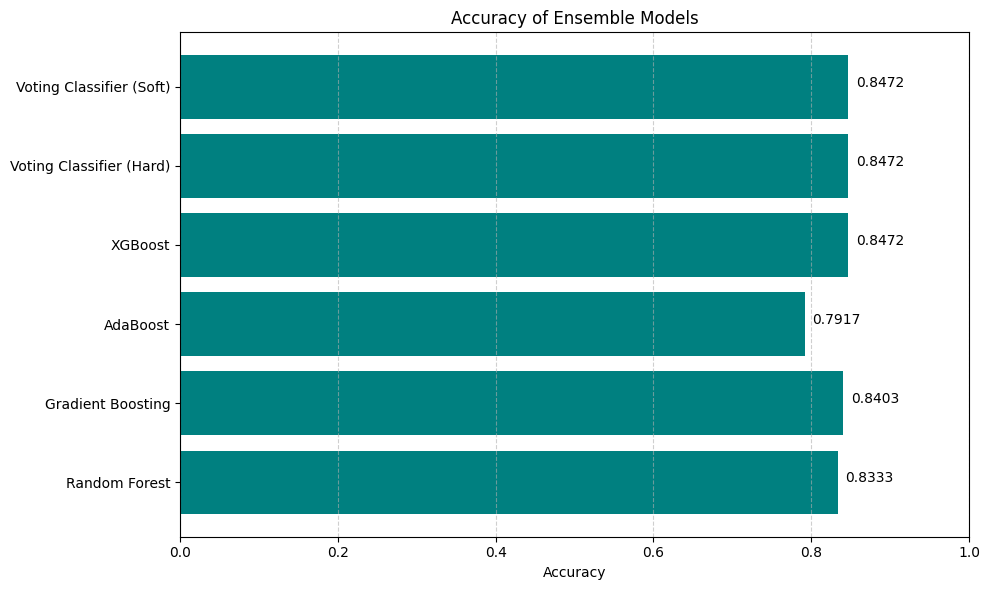

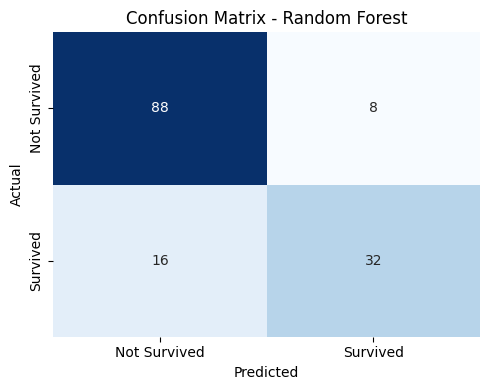

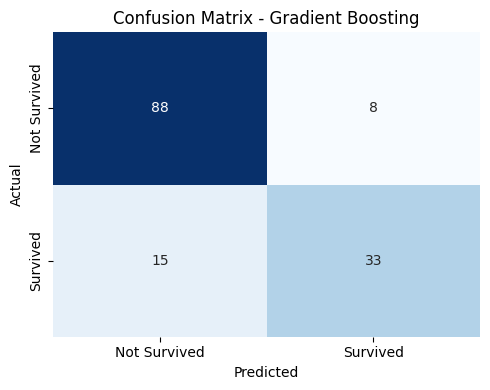

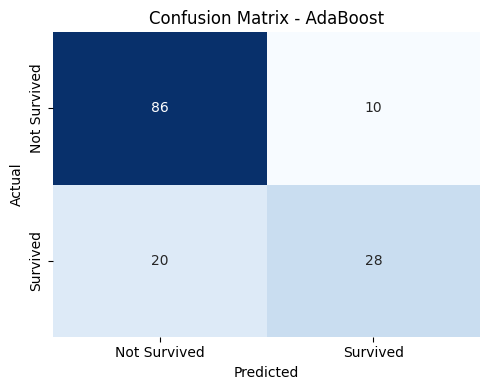

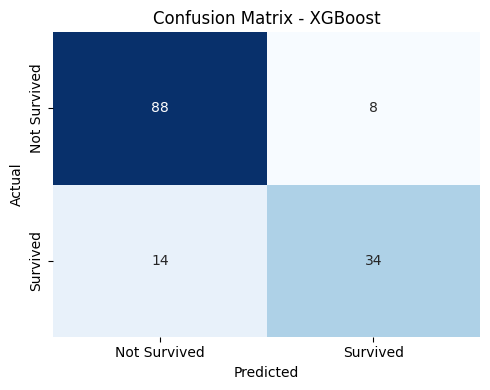

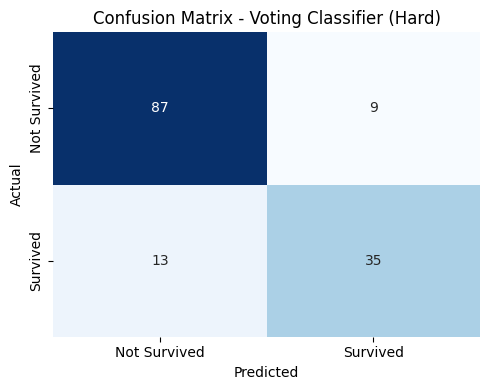

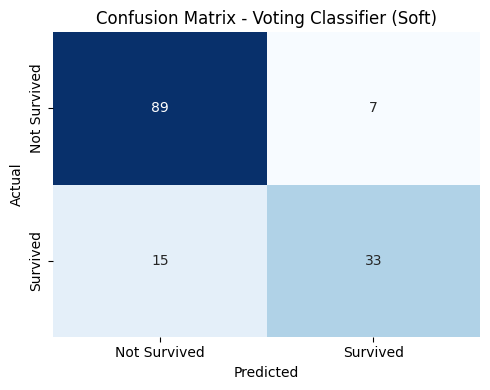

In [10]:
# Accuracy Plot
accuracies = {}
for model_name, (_, y_pred) in fitted_models.items():
    acc = accuracy_score(y_test, y_pred)
    accuracies[model_name] = acc

plt.figure(figsize=(10, 6))
plt.barh(list(accuracies.keys()), list(accuracies.values()), color='teal')
plt.xlabel('Accuracy')
plt.title('Accuracy of Ensemble Models')
plt.xlim(0, 1)
for index, value in enumerate(accuracies.values()):
    plt.text(value + 0.01, index, f'{value:.4f}')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Confusion Matrix Plots
for model_name, (_, y_pred) in fitted_models.items():
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Survived', 'Survived'],
                yticklabels=['Not Survived', 'Survived'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
